# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


In [1]:
version  = '17'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

fname1=mdir+edir+'icebox_train_rc_snow.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                        (cell: 2528737)
Dimensions without coordinates: cell
Data variables: (12/204)
    time                           (cell) float32 ...
    q_cloud                        (cell) float32 ...
    n_cloud                        (cell) float32 ...
    q_rain                         (cell) float32 ...
    n_rain                         (cell) float32 ...
    q_ice                          (cell) float32 ...
    ...                             ...
    frze_graupel_rain_mass         (cell) float32 ...
    frze_graupel_rain_rmass        (cell) float32 ...
    frze_graupel_rain_rvol         (cell) float32 ...
    frze_graupel_rain_liq          (cell) float32 ...
    rime_graupel_rain_num          (cell) float32 ...
    rime_graupel_rain_mass         (cell) float32 ...
Attributes:
    title:    McSnow ice microphysics box model output pre-processed by NCL
    date:     Mo 30 Mai 2022 10:06:20 CEST
    nfiles:   10013


# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    qi   = xr.open_dataset(fname).q_snow.values
    ni   = xr.open_dataset(fname).n_snow.values
    ssi  = xr.open_dataset(fname).ssi.values
    cwc  = xr.open_dataset(fname).cwc.values
    # process rates
    vel_num  = xr.open_dataset(fname).snow_vel_num.values
    vel_mass = xr.open_dataset(fname).snow_vel_mass.values
    # some numerical lower bounds
    q_min = 1e-12
    n_min = 1e-12
    z_min = 1e-20
    p_min = 1e-20
    # transform everything in log space
    ni = np.log(ni, where=ni>n_min, out=np.nan*ni)
    qi = np.log(qi, where=qi>q_min, out=np.nan*qi)
    vel_num  = np.log(vel_num,  where=vel_num>p_min, out=np.nan*vel_num)    
    vel_mass = np.log(vel_mass, where=vel_mass>p_min, out=np.nan*vel_mass)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ qi, ni, temp, rho, ssi, vel_num, vel_mass ]))
    dataset = dataset.T
    dataset.columns = [ 'qi', 'ni', 'temp', 'rho', 'ssi', 'vel_num', 'vel_mass' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

### Split in training, testing and validation with 70/15/15 rule

In [8]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]

df2 = df[~msk]
msk = np.random.rand(len(df2)) < 0.5

dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [9]:
dataset_train.head()

qi        ni        temp    rho     ssi   vel_num  vel_mass
0 -12.718099  6.595780  243.639999  0.698  0.0098 -0.877070 -0.721135
2 -12.225215  7.100027  243.779999  0.700  0.0098 -0.875149 -0.732304
3 -12.022685  7.286192  243.850006  0.701  0.0098 -0.870839 -0.733344
8 -11.475919  7.819234  244.220001  0.706  0.0098 -0.863936 -0.733136
9 -11.380320  7.909857  244.289993  0.707  0.0098 -0.864648 -0.733553

In [10]:
dataset_train.describe()

qi            ni          temp           rho           ssi  \
count  1.770074e+06  1.770074e+06  1.770074e+06  1.770074e+06  1.770074e+06   
mean  -8.925935e+00  1.061571e+01  2.412973e+02  6.882728e-01  4.387890e-03   
std    2.733804e+00  3.303051e+00  1.357553e+01  1.688869e-01  1.606982e-02   
min   -2.302555e+01 -1.449861e+01  2.066200e+02  4.120000e-01 -1.075000e-01   
25%   -1.005761e+01  9.847552e+00  2.314500e+02  5.610000e-01  0.000000e+00   
50%   -8.493354e+00  1.137412e+01  2.408200e+02  6.660000e-01  2.900000e-03   
75%   -7.104257e+00  1.262195e+01  2.496600e+02  7.760000e-01  3.800000e-03   
max   -4.008314e+00  1.607404e+01  2.850600e+02  1.288000e+00  3.028000e-01   

            vel_num      vel_mass  
count  1.770074e+06  1.770074e+06  
mean  -1.290192e+00 -9.116720e-01  
std    7.423334e-01  8.368437e-01  
min   -3.470547e+00 -3.470547e+00  
25%   -1.854699e+00 -1.540378e+00  
50%   -1.338648e+00 -9.571127e-01  
75%   -9.127969e-01 -3.673026e-01  
max    3.351307e+00  3.351307e+00

In [11]:
dataset_test.describe()

qi             ni           temp            rho  \
count  379153.000000  379153.000000  379153.000000  379153.000000   
mean       -8.924341      10.609407     241.300842       0.688456   
std         2.736017       3.308173      13.589648       0.169246   
min       -23.025751     -14.467842     206.899994       0.412000   
25%       -10.062413       9.845117     231.429993       0.561000   
50%        -8.487926      11.368962     240.809998       0.666000   
75%        -7.099618      12.617023     249.660004       0.777000   
max        -4.007268      16.019920     284.179993       1.288000   

                 ssi        vel_num       vel_mass  
count  379153.000000  379153.000000  379153.000000  
mean        0.004390      -1.288824      -0.910016  
std         0.015954       0.742515       0.836995  
min        -0.100100      -3.294138      -3.294138  
25%         0.000000      -1.852784      -1.539446  
50%         0.002900      -1.337504      -0.954512  
75%         0.003800      -0.909067      -0.362693  
max         0.297100       2.511224       2.511224

In [12]:
dataset_val.describe()

qi             ni           temp            rho  \
count  379510.000000  379510.000000  379510.000000  379510.000000   
mean       -8.933413      10.604200     241.309937       0.688476   
std         2.747715       3.308689      13.583444       0.169078   
min       -23.025351     -14.498609     206.970001       0.412000   
25%       -10.067372       9.835637     231.460007       0.562000   
50%        -8.498224      11.362288     240.820007       0.667000   
75%        -7.101659      12.611871     249.690002       0.777000   
max        -4.006059      15.985855     285.700012       1.288000   

                 ssi        vel_num       vel_mass  
count  379510.000000  379510.000000  379510.000000  
mean        0.004445      -1.288505      -0.910360  
std         0.016307       0.741369       0.835384  
min        -0.112900      -3.511570      -3.511570  
25%         0.000000      -1.852147      -1.538514  
50%         0.002900      -1.334461      -0.952955  
75%         0.003800      -0.910060      -0.366870  
max         0.296300       2.496506       2.496506

### Further reduce data to relevant parameter range

In [13]:
def reduce_data(dataset):
    idx = dataset[ dataset['qi'] < -20 ].index
    dataset.drop(idx,inplace=True)   
    idx = dataset[ dataset['ni'] < -1 ].index
    dataset.drop(idx,inplace=True)   
    idx = dataset[ dataset['vel_num'] < -2.5 ].index
    dataset.drop(idx,inplace=True)   
    idx = dataset[ dataset['vel_mass'] < -2.5 ].index
    dataset.drop(idx,inplace=True)   
    idx = dataset[ dataset['temp'] > 273 ].index
    dataset.drop(idx,inplace=True)   
    return dataset

In [14]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [15]:
dataset_train.describe()

qi            ni          temp           rho           ssi  \
count  1.707255e+06  1.707255e+06  1.707255e+06  1.707255e+06  1.707255e+06   
mean  -8.792382e+00  1.098563e+01  2.402714e+02  6.737651e-01  4.603818e-03   
std    2.376613e+00  2.567464e+00  1.252998e+01  1.506677e-01  1.525588e-02   
min   -1.999998e+01 -9.994821e-01  2.066200e+02  4.120000e-01  0.000000e+00   
25%   -9.982856e+00  1.007239e+01  2.310900e+02  5.580000e-01  2.000000e-03   
50%   -8.487198e+00  1.145881e+01  2.403100e+02  6.600000e-01  2.900000e-03   
75%   -7.127255e+00  1.267050e+01  2.486400e+02  7.630000e-01  3.800000e-03   
max   -4.012285e+00  1.607404e+01  2.730000e+02  1.279000e+00  3.028000e-01   

            vel_num      vel_mass  
count  1.707255e+06  1.707255e+06  
mean  -1.329497e+00 -9.391146e-01  
std    6.867984e-01  8.084479e-01  
min   -2.499939e+00 -2.499939e+00  
25%   -1.868209e+00 -1.550697e+00  
50%   -1.364924e+00 -9.733903e-01  
75%   -9.393035e-01 -4.150610e-01  
max    5.749265e-01  8.548408e-01

In [16]:
dataset_test.describe()

qi             ni           temp            rho  \
count  365700.000000  365700.000000  365700.000000  365700.000000   
mean       -8.791008      10.980319     240.274918       0.673924   
std         2.379416       2.570331      12.547262       0.151026   
min       -19.999153      -0.997528     206.899994       0.412000   
25%        -9.987804      10.074232     231.059998       0.558000   
50%        -8.482357      11.453918     240.309998       0.660000   
75%        -7.122518      12.666231     248.630005       0.763000   
max        -4.014111      16.019920     273.000000       1.259000   

                 ssi        vel_num       vel_mass  
count  365700.000000  365700.000000  365700.000000  
mean        0.004607      -1.328074      -0.937394  
std         0.015175       0.687217       0.808887  
min         0.000000      -2.499939      -2.497384  
25%         0.002000      -1.866914      -1.549755  
50%         0.002900      -1.363750      -0.971275  
75%         0.003900      -0.937004      -0.411999  
max         0.297100       0.552159       0.867101

### Pairplot

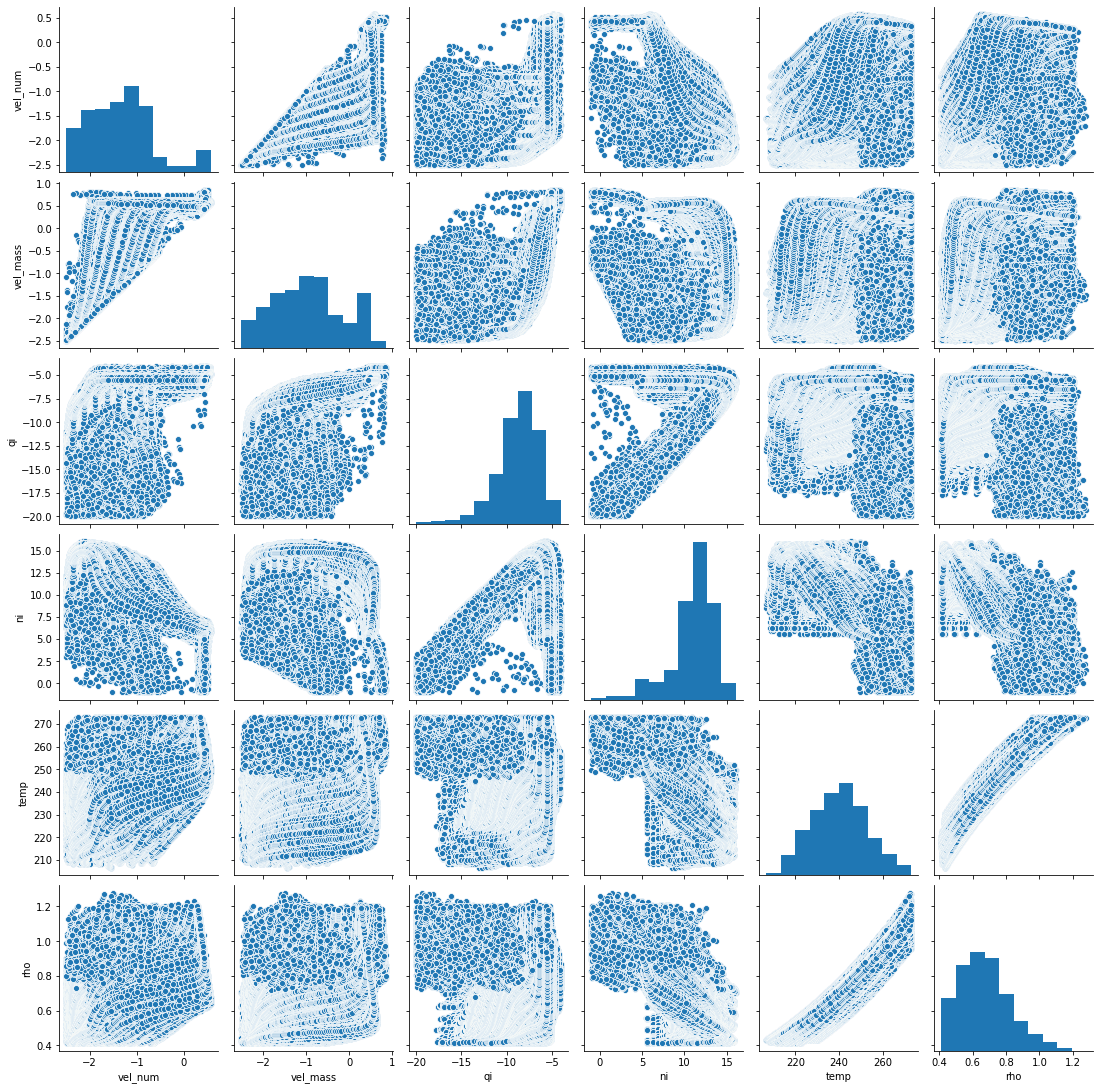

In [17]:
sns.pairplot(dataset_train[["vel_num","vel_mass","qi","ni","temp","rho"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [18]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()
train_dataset4 = dataset_train.copy()
train_dataset5 = dataset_train.copy()

In [19]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()
test_dataset4 = dataset_test.copy()
test_dataset5 = dataset_test.copy()

In [20]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()
val_dataset4 = dataset_val.copy()
val_dataset5 = dataset_val.copy()

In [21]:
train_dataset1 = train_dataset1.drop(['temp','rho','ssi'], axis=1)
train_dataset2 = train_dataset2.drop(['temp','ssi'], axis=1)
train_dataset3 = train_dataset3.drop(['ssi'], axis=1)
#train_dataset4 = train_dataset4.drop(['zi'], axis=1)
#train_dataset5 = train_dataset5.drop(['qs'], axis=1)

In [22]:
test_dataset1 = test_dataset1.drop(['temp','rho','ssi'], axis=1)
test_dataset2 = test_dataset2.drop(['temp','ssi'], axis=1)
test_dataset3 = test_dataset3.drop(['ssi'], axis=1)
#test_dataset4 = test_dataset4.drop(['zi'], axis=1)
#test_dataset5 = test_dataset5.drop(['qs'], axis=1)

In [23]:
val_dataset1 = val_dataset1.drop(['temp','rho','ssi'], axis=1)
val_dataset2 = val_dataset2.drop(['temp','ssi'], axis=1)
val_dataset3 = val_dataset3.drop(['ssi'], axis=1)
#val_dataset4 = val_dataset4.drop(['zi'], axis=1)
#val_dataset5 = val_dataset5.drop(['qs'], axis=1)

In [24]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("vel_num")
train_stats1.pop("vel_mass")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min        25%        50%  \
qi  1707255.0  -8.792382  2.376613 -19.999977  -9.982856  -8.487198   
ni  1707255.0  10.985631  2.567464  -0.999482  10.072386  11.458807   

          75%        max  
qi  -7.127255  -4.012285  
ni  12.670498  16.074039

In [25]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("vel_num")
train_stats2.pop("vel_mass")
train_stats2 = train_stats2.transpose()
train_stats2

count       mean       std        min        25%        50%  \
qi   1707255.0  -8.792382  2.376613 -19.999977  -9.982856  -8.487198   
ni   1707255.0  10.985631  2.567464  -0.999482  10.072386  11.458807   
rho  1707255.0   0.673765  0.150668   0.412000   0.558000   0.660000   

           75%        max  
qi   -7.127255  -4.012285  
ni   12.670498  16.074039  
rho   0.763000   1.279000

In [26]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("vel_num")
train_stats3.pop("vel_mass")
train_stats3 = train_stats3.transpose()
train_stats3

count        mean        std         min         25%         50%  \
qi    1707255.0   -8.792382   2.376613  -19.999977   -9.982856   -8.487198   
ni    1707255.0   10.985631   2.567464   -0.999482   10.072386   11.458807   
temp  1707255.0  240.271423  12.529979  206.619995  231.089996  240.309998   
rho   1707255.0    0.673765   0.150668    0.412000    0.558000    0.660000   

             75%         max  
qi     -7.127255   -4.012285  
ni     12.670498   16.074039  
temp  248.639999  273.000000  
rho     0.763000    1.279000

In [27]:
train_stats4 = train_dataset4.describe()
train_stats4.pop("vel_num")
train_stats4.pop("vel_mass")
train_stats4 = train_stats4.transpose()
train_stats4

count        mean        std         min         25%         50%  \
qi    1707255.0   -8.792382   2.376613  -19.999977   -9.982856   -8.487198   
ni    1707255.0   10.985631   2.567464   -0.999482   10.072386   11.458807   
temp  1707255.0  240.271423  12.529979  206.619995  231.089996  240.309998   
rho   1707255.0    0.673765   0.150668    0.412000    0.558000    0.660000   
ssi   1707255.0    0.004604   0.015256    0.000000    0.002000    0.002900   

             75%         max  
qi     -7.127255   -4.012285  
ni     12.670498   16.074039  
temp  248.639999  273.000000  
rho     0.763000    1.279000  
ssi     0.003800    0.302800

In [28]:
train_stats5 = train_dataset5.describe()
train_stats5.pop("vel_num")
train_stats5.pop("vel_mass")
train_stats5 = train_stats5.transpose()
train_stats5

count        mean        std         min         25%         50%  \
qi    1707255.0   -8.792382   2.376613  -19.999977   -9.982856   -8.487198   
ni    1707255.0   10.985631   2.567464   -0.999482   10.072386   11.458807   
temp  1707255.0  240.271423  12.529979  206.619995  231.089996  240.309998   
rho   1707255.0    0.673765   0.150668    0.412000    0.558000    0.660000   
ssi   1707255.0    0.004604   0.015256    0.000000    0.002000    0.002900   

             75%         max  
qi     -7.127255   -4.012285  
ni     12.670498   16.074039  
temp  248.639999  273.000000  
rho     0.763000    1.279000  
ssi     0.003800    0.302800

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [29]:
# pop does not work for multiple columns, use copy instead

labels = ['vel_num','vel_mass']

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [30]:
train_dataset2.drop(labels, axis=1, inplace=True)
test_dataset2.drop(labels, axis=1, inplace=True)
val_dataset2.drop(labels, axis=1, inplace=True)

In [31]:
train_dataset3.drop(labels, axis=1, inplace=True)
test_dataset3.drop(labels, axis=1, inplace=True)
val_dataset3.drop(labels, axis=1, inplace=True)

In [32]:
train_dataset4.drop(labels, axis=1, inplace=True)
test_dataset4.drop(labels, axis=1, inplace=True)
val_dataset4.drop(labels, axis=1, inplace=True)

In [33]:
train_dataset5.drop(labels, axis=1, inplace=True)
test_dataset5.drop(labels, axis=1, inplace=True)
val_dataset5.drop(labels, axis=1, inplace=True)

In [34]:
train_labels.describe()

vel_num      vel_mass
count  1.707255e+06  1.707255e+06
mean  -1.329497e+00 -9.391146e-01
std    6.867984e-01  8.084479e-01
min   -2.499939e+00 -2.499939e+00
25%   -1.868209e+00 -1.550697e+00
50%   -1.364924e+00 -9.733903e-01
75%   -9.393035e-01 -4.150610e-01
max    5.749265e-01  8.548408e-01

In [35]:
train_dataset1.describe()

qi            ni
count  1.707255e+06  1.707255e+06
mean  -8.792382e+00  1.098563e+01
std    2.376613e+00  2.567464e+00
min   -1.999998e+01 -9.994821e-01
25%   -9.982856e+00  1.007239e+01
50%   -8.487198e+00  1.145881e+01
75%   -7.127255e+00  1.267050e+01
max   -4.012285e+00  1.607404e+01

In [36]:
train_dataset2.describe()

qi            ni           rho
count  1.707255e+06  1.707255e+06  1.707255e+06
mean  -8.792382e+00  1.098563e+01  6.737651e-01
std    2.376613e+00  2.567464e+00  1.506677e-01
min   -1.999998e+01 -9.994821e-01  4.120000e-01
25%   -9.982856e+00  1.007239e+01  5.580000e-01
50%   -8.487198e+00  1.145881e+01  6.600000e-01
75%   -7.127255e+00  1.267050e+01  7.630000e-01
max   -4.012285e+00  1.607404e+01  1.279000e+00

In [37]:
train_dataset3.describe()

qi            ni          temp           rho
count  1.707255e+06  1.707255e+06  1.707255e+06  1.707255e+06
mean  -8.792382e+00  1.098563e+01  2.402714e+02  6.737651e-01
std    2.376613e+00  2.567464e+00  1.252998e+01  1.506677e-01
min   -1.999998e+01 -9.994821e-01  2.066200e+02  4.120000e-01
25%   -9.982856e+00  1.007239e+01  2.310900e+02  5.580000e-01
50%   -8.487198e+00  1.145881e+01  2.403100e+02  6.600000e-01
75%   -7.127255e+00  1.267050e+01  2.486400e+02  7.630000e-01
max   -4.012285e+00  1.607404e+01  2.730000e+02  1.279000e+00

### Normalize the features

In [38]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)
normed_train_data4 = norm(train_dataset4,train_stats4)
normed_train_data5 = norm(train_dataset5,train_stats5)

normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)
normed_test_data4 = norm(test_dataset4,train_stats4)
normed_test_data5 = norm(test_dataset5,train_stats5)

normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)
normed_val_data3 = norm(val_dataset3,train_stats3)
normed_val_data4 = norm(val_dataset4,train_stats4)
normed_val_data5 = norm(val_dataset5,train_stats5)

In [39]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean  std       min       25%       50%       75%  \
qi  1707255.0  6.614173e-07  1.0 -4.715784 -0.500912  0.128411  0.700630   
ni  1707255.0 -8.289374e-07  1.0 -4.668074 -0.355699  0.184297  0.656238   

         max  
qi  2.011306  
ni  1.981881

In [40]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean  std       min       25%       50%       75%  \
qi   1707255.0  6.614173e-07  1.0 -4.715784 -0.500912  0.128411  0.700630   
ni   1707255.0 -8.289374e-07  1.0 -4.668074 -0.355699  0.184297  0.656238   
rho  1707255.0  3.466772e-07  1.0 -1.737367 -0.768347 -0.091361  0.592263   

          max  
qi   2.011306  
ni   1.981881  
rho  4.017018

In [41]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean  std       min       25%       50%       75%  \
qi    1707255.0  6.614173e-07  1.0 -4.715784 -0.500912  0.128411  0.700630   
ni    1707255.0 -8.289374e-07  1.0 -4.668074 -0.355699  0.184297  0.656238   
temp  1707255.0  7.970927e-06  1.0 -2.685673 -0.732757  0.003079  0.667884   
rho   1707255.0  3.466772e-07  1.0 -1.737367 -0.768347 -0.091361  0.592263   

           max  
qi    2.011306  
ni    1.981881  
temp  2.612022  
rho   4.017018

In [42]:
normed_train_stats4 = normed_train_data4.describe()
normed_train_stats4 = normed_train_stats4.transpose()
normed_train_stats4

count          mean  std       min       25%       50%       75%  \
qi    1707255.0  6.614173e-07  1.0 -4.715784 -0.500912  0.128411  0.700630   
ni    1707255.0 -8.289374e-07  1.0 -4.668074 -0.355699  0.184297  0.656238   
temp  1707255.0  7.970927e-06  1.0 -2.685673 -0.732757  0.003079  0.667884   
rho   1707255.0  3.466772e-07  1.0 -1.737367 -0.768347 -0.091361  0.592263   
ssi   1707255.0 -9.536015e-08  1.0 -0.301773 -0.170676 -0.111683 -0.052689   

            max  
qi     2.011306  
ni     1.981881  
temp   2.612022  
rho    4.017018  
ssi   19.546317

In [43]:
normed_train_stats5 = normed_train_data5.describe()
normed_train_stats5 = normed_train_stats5.transpose()
normed_train_stats5

count          mean  std       min       25%       50%       75%  \
qi    1707255.0  6.614173e-07  1.0 -4.715784 -0.500912  0.128411  0.700630   
ni    1707255.0 -8.289374e-07  1.0 -4.668074 -0.355699  0.184297  0.656238   
temp  1707255.0  7.970927e-06  1.0 -2.685673 -0.732757  0.003079  0.667884   
rho   1707255.0  3.466772e-07  1.0 -1.737367 -0.768347 -0.091361  0.592263   
ssi   1707255.0 -9.536015e-08  1.0 -0.301773 -0.170676 -0.111683 -0.052689   

            max  
qi     2.011306  
ni     1.981881  
temp   2.612022  
rho    4.017018  
ssi   19.546317

### Normalize the labels

In [44]:
train_labels_stats = train_labels.describe()
train_labels_stats = train_labels_stats.transpose()
train_labels_stats

count      mean       std       min       25%       50%  \
vel_num   1707255.0 -1.329497  0.686798 -2.499939 -1.868209 -1.364924   
vel_mass  1707255.0 -0.939115  0.808448 -2.499939 -1.550697 -0.973390   

               75%       max  
vel_num  -0.939304  0.574926  
vel_mass -0.415061  0.854841

In [45]:
normed_train_labels = norm(train_labels,train_labels_stats)
normed_test_labels = norm(test_labels,train_labels_stats)
normed_val_labels = norm(val_labels,train_labels_stats)

# The model

## Build the model

In [46]:
def build_model_sigm(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H2(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H1(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,nsize,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,nsize,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,nsize,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,nsize,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H1":
        model = build_model_relu_Adam_H1(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H2":
        model = build_model_relu_Adam_H2(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD_H6":
        model = build_model_relu_SGD_H6(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H6":
        model = build_model_relu_Adam_H6(ncol,nsize,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,nsize,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,nsize,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [47]:

activ = "ReLU_Adam_H1"

model = build_model(2,6,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 18        
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 14        
Total params: 74
Trainable params: 74
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [49]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.86637324, -0.5584579 ],
       [ 0.7574302 , -0.4836035 ],
       [ 0.7125894 , -0.45072046],
       [ 0.59164226, -0.36502308],
       [ 0.570486  , -0.34977898],
       [ 0.5325795 , -0.3232418 ],
       [ 0.51814723, -0.3131249 ],
       [ 0.5048244 , -0.3032491 ],
       [ 0.48145068, -0.28693372],
       [ 0.47000018, -0.27906483]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [50]:
# maximum number, but we use early stopping
EPOCHS = 300

# learning rate
learn = 1e-3       # original value is 1e-3, but smaller might be better?

# width of neural net
nsize = 16

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=10)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [51]:
nsize = 8
activ = "ReLU_Adam_H1"
model1 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history1 = model1.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0321,  mae:0.0955,  mse:0.0321,  val_loss:0.0230,  val_mae:0.0874,  val_mse:0.0230,  
...............................

Text(0, 0.5, 'MAE')

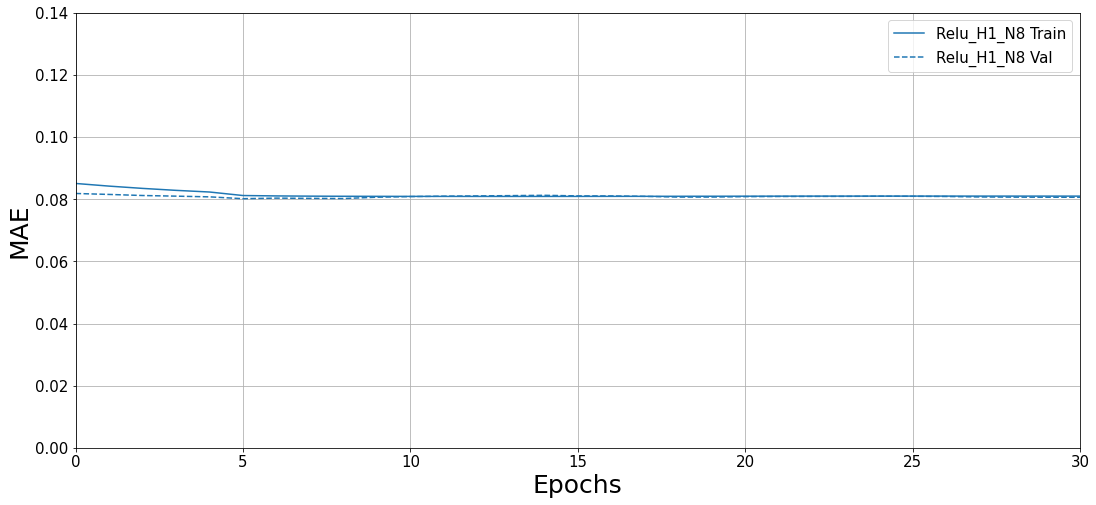

In [52]:
histories['ReLU_H1_n8'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.0,0.14])
plt.ylabel('MAE')

In [53]:
nsize = 16
model2 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history2 = model2.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0245,  mae:0.0871,  mse:0.0245,  val_loss:0.0220,  val_mae:0.0833,  val_mse:0.0220,  
......................................................................

Text(0, 0.5, 'MAE')

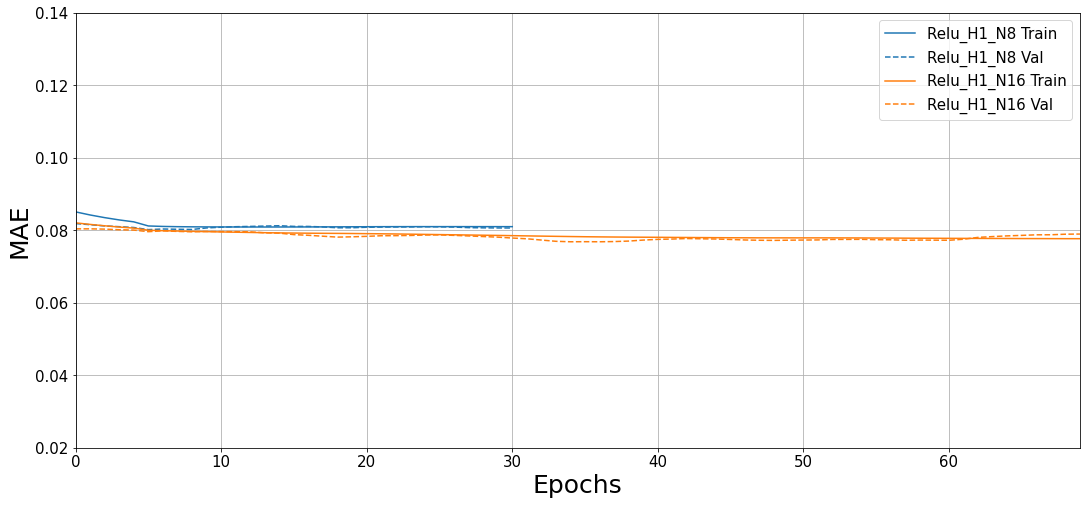

In [54]:
histories['ReLU_H1_n16'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.02, 0.14])
plt.ylabel('MAE')

In [55]:
nsize = 8
activ = "ReLU_Adam_H2"
model3 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history3 = model3.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0280,  mae:0.0939,  mse:0.0280,  val_loss:0.0228,  val_mae:0.0873,  val_mse:0.0228,  
.............................................

Text(0, 0.5, 'MAE')

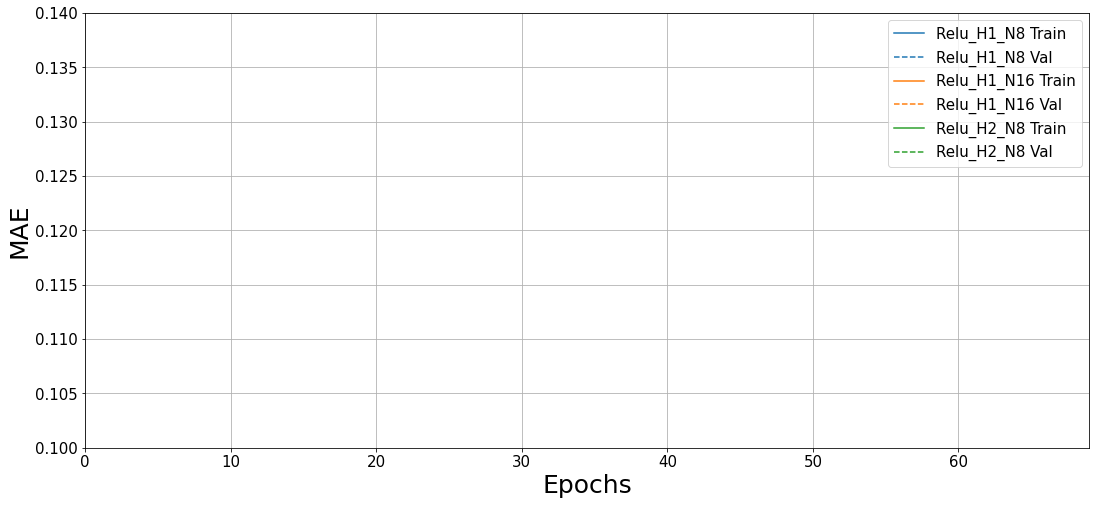

In [56]:
histories['ReLU_H2_n8'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.1, 0.14])
plt.ylabel('MAE')

In [57]:
nsize = 16
activ = "ReLU_Adam_H2"
model4 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history4 = model4.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0248,  mae:0.0868,  mse:0.0248,  val_loss:0.0221,  val_mae:0.0836,  val_mse:0.0221,  
...............................

Text(0, 0.5, 'MAE')

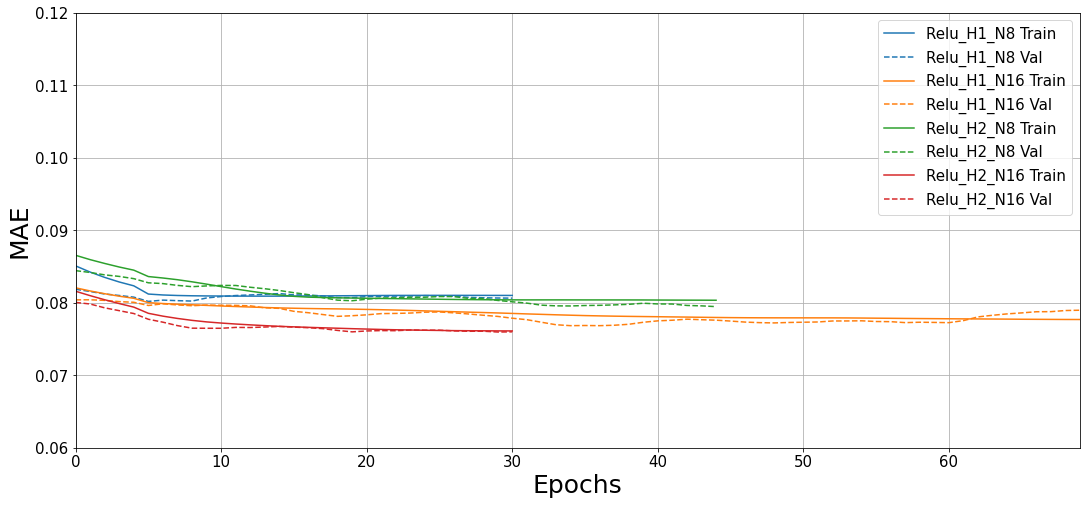

In [63]:
histories['ReLU_H2_n16'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.06, 0.12])
plt.ylabel('MAE')

Text(0, 0.5, 'MSE')

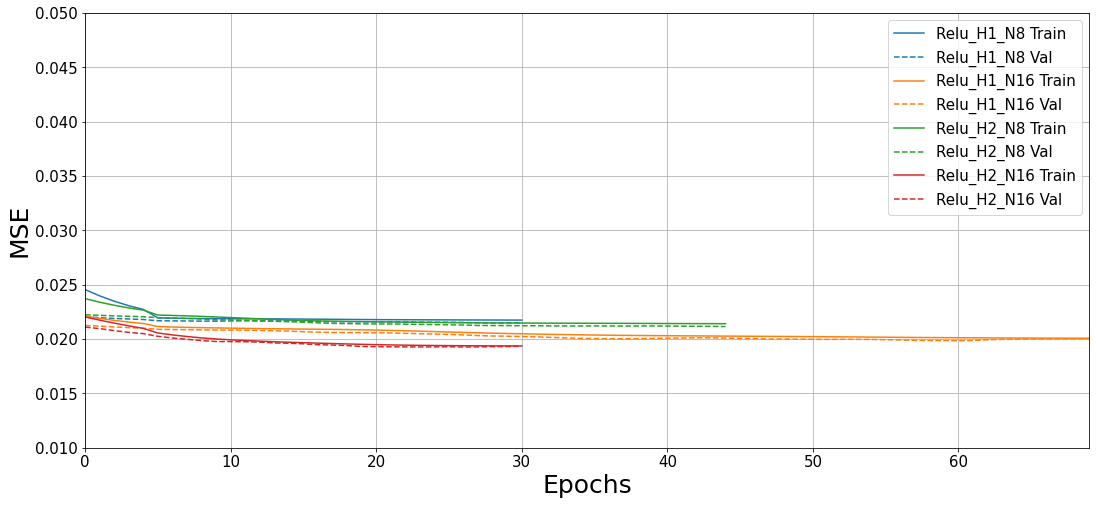

In [61]:
plotter.plot(histories, metric = "mse")
plt.ylim([0.01, 0.05])
plt.ylabel('MSE')

In [64]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

365700/365700 - 8s - loss: 0.0217 - mae: 0.0807 - mse: 0.0217
Testing set for model 1, Mean Abs Error:    0.08067


In [65]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:20.5f}".format(mae2))

365700/365700 - 8s - loss: 0.0200 - mae: 0.0762 - mse: 0.0200
Testing set for model 2, Mean Abs Error:              0.07616


In [66]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:20.5f}".format(mae3))

365700/365700 - 9s - loss: 0.0213 - mae: 0.0792 - mse: 0.0213
Testing set for model 3, Mean Abs Error:              0.07917


In [67]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:20.5f}".format(mae4))

365700/365700 - 9s - loss: 0.0193 - mae: 0.0755 - mse: 0.0193
Testing set for model 4, Mean Abs Error:              0.07553


In [68]:
mae = [ mae1, mae2, mae3, mae4 ]
mae

[0.080673404, 0.07615565, 0.07917286, 0.07553491]

In [69]:
mse = [ mse1, mse2, mse3, mse4 ]
mse

[0.021731617, 0.020044873, 0.021326939, 0.0193027]

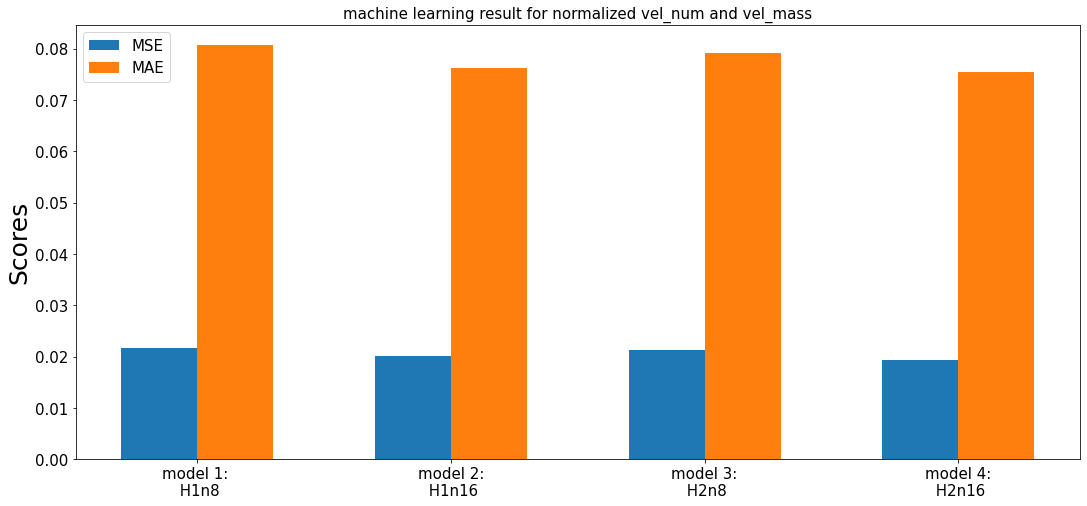

In [70]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = ['model 1: \n H1n8',
 'model 2:\n H1n16',
 'model 3:\n H2n8',
 'model 4:\n H2n16' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse, width, label='MSE')
rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for normalized vel_num and vel_mass')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [71]:
test_true_num  = np.exp(test_labels.pop('vel_num'))
test_true_mass = np.exp(test_labels.pop('vel_mass'))

In [72]:
def backtransform(x,stats):
  return x*stats['std']+stats['mean']

In [73]:
p1 = pd.DataFrame(data=model1.predict(normed_test_data3), columns=["vel_num", "vel_mass"])

In [74]:
p1.describe()

vel_num       vel_mass
count  365700.000000  365700.000000
mean       -0.000374       0.008103
std         0.988605       0.990634
min        -1.718220      -1.889788
25%        -0.769273      -0.735642
50%        -0.023421      -0.030622
75%         0.555246       0.648926
max         2.748629       2.313373

In [75]:
train_labels_stats

count      mean       std       min       25%       50%  \
vel_num   1707255.0 -1.329497  0.686798 -2.499939 -1.868209 -1.364924   
vel_mass  1707255.0 -0.939115  0.808448 -2.499939 -1.550697 -0.973390   

               75%       max  
vel_num  -0.939304  0.574926  
vel_mass -0.415061  0.854841

In [76]:
test_predict1 = np.exp(backtransform(p1,train_labels_stats))

In [77]:
test_predict1.describe()

vel_num       vel_mass
count  365700.000000  365700.000000
mean        0.343916       0.541443
std         0.311901       0.452302
min         0.081303       0.084847
25%         0.156010       0.215705
50%         0.260388       0.381413
75%         0.387455       0.660676
max         1.747624       2.537366

In [78]:
test_predict1_num  = test_predict1['vel_num']
test_predict1_mass = test_predict1['vel_mass']

In [79]:

p2 = pd.DataFrame(data=model1.predict(normed_test_data3), columns=["vel_num", "vel_mass"])

test_predict2 = np.exp(backtransform(p2,train_labels_stats))

test_predict2_num  = test_predict2['vel_num']
test_predict2_mass = test_predict2['vel_mass']

In [80]:

p3 = pd.DataFrame(data=model2.predict(normed_test_data3), columns=["vel_num", "vel_mass"])

test_predict3 = np.exp(backtransform(p3,train_labels_stats))

test_predict3_num  = test_predict3['vel_num']
test_predict3_mass = test_predict3['vel_mass']

In [81]:

p4 = pd.DataFrame(data=model3.predict(normed_test_data3), columns=["vel_num", "vel_mass"])

test_predict4 = np.exp(backtransform(p4,train_labels_stats))

test_predict4_num  = test_predict4['vel_num']
test_predict4_mass = test_predict4['vel_mass']

### Maybe the ordering of the arrays is different? 

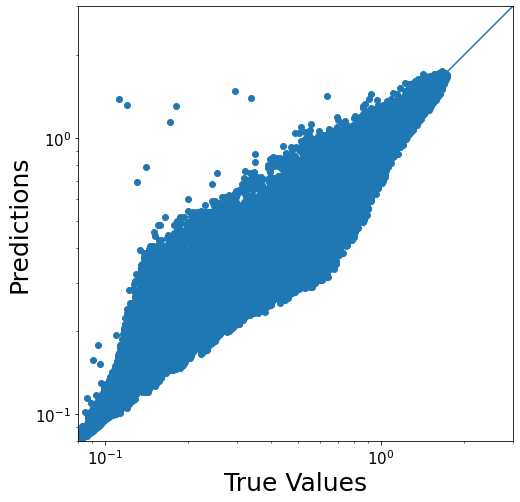

In [82]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

amin, amax = 8e-2, 3

a = plt.axes(aspect='equal')
plt.scatter(test_true_num, test_predict1_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

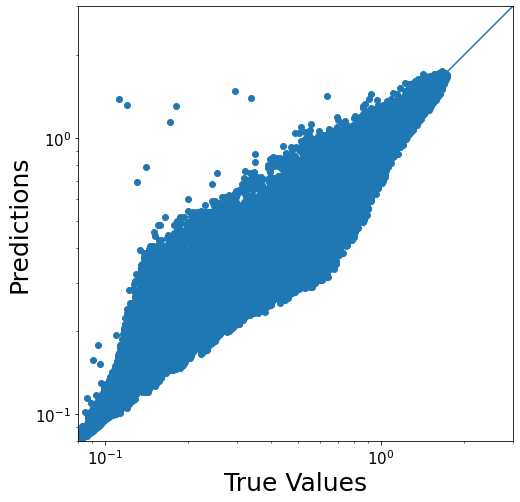

In [83]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_num, test_predict2_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

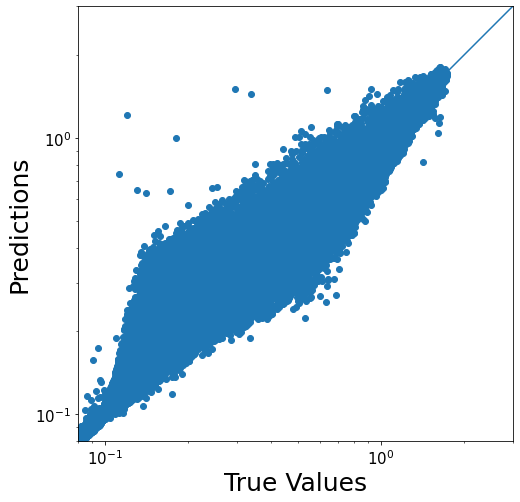

In [84]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_num, test_predict3_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

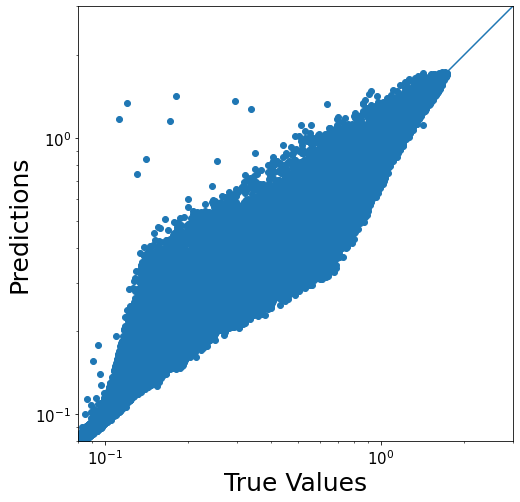

In [85]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_num, test_predict4_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

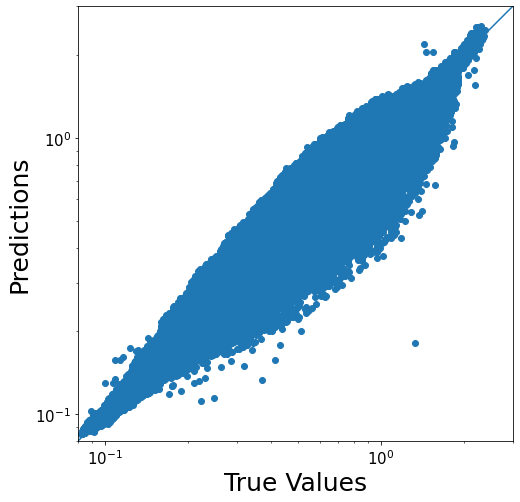

In [86]:
amin, amax = 8e-2, 3

a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict1_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

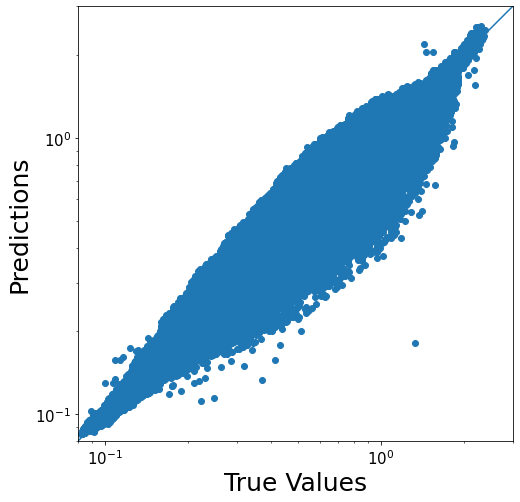

In [87]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict2_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

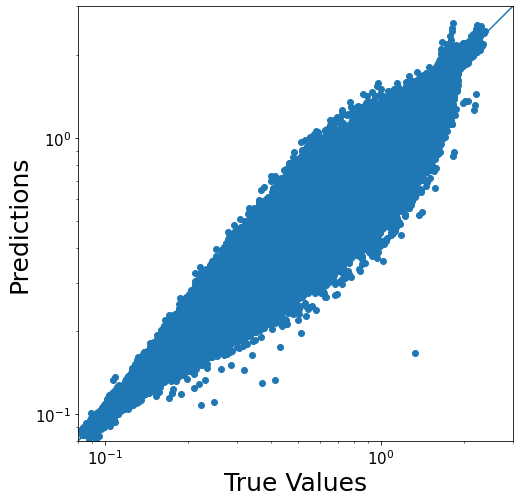

In [88]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict3_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

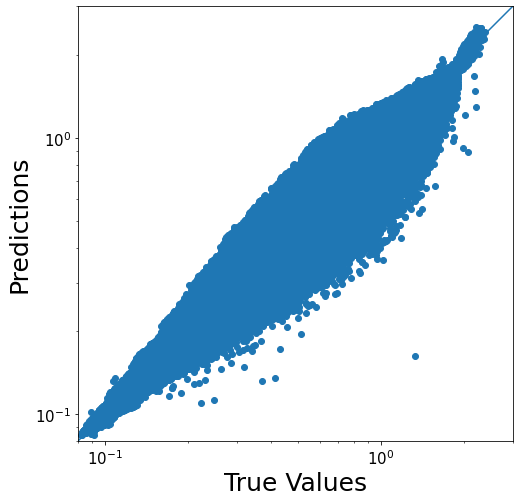

In [89]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict4_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save models to file

In [90]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2
   

In [91]:
def save2netcdf(model, features_str, labels_str, features_norm, labels_norm, features_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

        
    # write arrays for logtransform and normalization of input and output data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    D["out_norm_mean"] = xr.DataArray(labels_norm['mean'].values, dims=("Nout_{}".format(nout)))
    D["out_norm_std"]  = xr.DataArray(labels_norm['std'].values, dims=("Nout_{}".format(nout)))
    
    D.to_netcdf(outpath)

In [92]:
features = 'qs, ns, temp, rho'
labels   = 'vel_snow_num, vel_snow_mass'
logtransform = np.array([True, True, False, False], dtype=bool)

save2netcdf(model1,features,labels,train_stats3,train_labels_stats,logtransform,'saved_model_v2/vel_snow_model1_'+version+'.nc')
save2netcdf(model2,features,labels,train_stats3,train_labels_stats,logtransform,'saved_model_v2/vel_snow_model2_'+version+'.nc')
save2netcdf(model3,features,labels,train_stats3,train_labels_stats,logtransform,'saved_model_v2/vel_snow_model3_'+version+'.nc')
save2netcdf(model4,features,labels,train_stats3,train_labels_stats,logtransform,'saved_model_v2/vel_snow_model4_'+version+'.nc')


Saving model to saved_model_v2/vel_snow_model1_17.nc
  Features:   qs, ns, temp, rho
  Labels:     vel_snow_num, vel_snow_mass
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 8), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (8, 8), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (8, 2), Activation: linear
Saving model to saved_model_v2/vel_snow_model2_17.nc
  Features:   qs, ns, temp, rho
  Labels:     vel_snow_num, vel_snow_mass
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 2), Activation: linear
Saving model to saved_model_v2/vel_snow_model3_17.nc
  Features:   qs, ns, temp, rho
  Labels:     vel_snow_num, vel_snow_mass
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 8), Activ

In [93]:
activ = "ReLU_Adam_H1"
model = build_model(4,8,activ,1e-3)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 18        
Total params: 130
Trainable params: 130
Non-trainable params: 0
_________________________________________________________________


In [94]:
activ = "ReLU_Adam_H1"
model = build_model(4,16,activ,1e-3)
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 16)                80        
_________________________________________________________________
dense_21 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_22 (Dense)             (None, 2)                 34        
Total params: 386
Trainable params: 386
Non-trainable params: 0
_________________________________________________________________


In [95]:
activ = "ReLU_Adam_H2"
model = build_model(4,8,activ,1e-3)
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_24 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_25 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 18        
Total params: 202
Trainable params: 202
Non-trainable params: 0
_________________________________________________________________


In [96]:
activ = "ReLU_Adam_H2"
model = build_model(4,16,activ,1e-3)
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 16)                80        
_________________________________________________________________
dense_28 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_29 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_30 (Dense)             (None, 2)                 34        
Total params: 658
Trainable params: 658
Non-trainable params: 0
_________________________________________________________________
